In [53]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
import torch.optim as optim


df=pd.read_csv('./data/051910.csv',index_col=0).reset_index(drop=True)
# df=pd.read_csv('./data/215600.csv',index_col=0).reset_index(drop=True)
code_name=pd.read_csv('./data/code_name.csv')
train=df[['open','high','low','volume']]
target=df[['close']]
dates=df.date

In [73]:
class custom_dataset(Dataset):
    '''sequence 만들기 및 정규화 추가 해야됨'''
    def __init__(self,train,target,window_size=5):
        self.window_size=window_size
        self.len=train.shape[0]
        self.train=train
        self.target=target

    def __getitem__(self,index):
        return self.train[index],self.target[index]
    
    def __len__(self):
        return self.len

In [15]:
def split_data(data):
    '''train,val,test 나누기'''
    prop=len(data)//5
    val=data[:prop]
    test=data[prop+1:2*prop]
    train=data[2*prop:]
    
    return np.array(train),np.array(val),np.array(test)

def make_seq(data,window_size):
    seq_data=[]
    for i in range(data.shape[0]-window_size):
        L=data[i:i+window_size]
        seq_data.append(L)
    return seq_data

def make_nomarlized_seq(data,window_size):
    '''input : pandas df, window size만큼만 normalize'''
    seq_data=[]
    scaler= StandardScaler()
    for i in range(data.shape[0]-window_size):
        L=data[i:i+window_size]
        seq_data.append(scaler.fit_transform(np.array(L)))
        
    return np.array(seq_data),scaler

def preprocessing(data):
    '''정규화 및 numpy array return : 이제 안쓸듯'''
    scaler= StandardScaler()
    data=scaler.fit_transform(data)
    data=np.array(data)
    
    return data

In [16]:
# train_data_normalized,scaler_train = preprocessing(train.iloc[:-1])
# target_data_normalized ,scaler_test= preprocessing(target.iloc[1:])

# train_seq=make_seq(train_data_normalized,window_size=5)
# target_seq=make_seq(target_data_normalized,window_size=5)

'''making normalized window'''
train_seq,train_scaler=make_nomarlized_seq(train.iloc[:-1],window_size=5)
test_seq,test_scaler=make_nomarlized_seq(target.iloc[1:],window_size=5)

x_train,x_val,x_test=split_data(train_seq)
y_train,y_val,y_test=split_data(test_seq)

In [18]:
train_dataset=custom_dataset(train=x_train,target=y_train)
train_loader=DataLoader(train_dataset,batch_size=4)

### LSTM을 이용한 예측

In [19]:
class stock_net(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        
        super(stock_net, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.h_o=nn.Linear(hidden_dim,1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        
        x=self.lstm(x)
        x=self.relu(self.h_o(x[0]))
        
        return x

In [20]:
emb_dim=x_train.shape[2] # feature size

In [65]:
haha_net=stock_net(emb_dim,5)
criterion = nn.MSELoss()
optimizer = optim.SGD(haha_net.parameters(), lr=0.01)

In [66]:
# Loss=[]
# epoch=1
# for y in range(epoch):
#     for i in range(x_train.shape[0]):

#         optimizer.zero_grad()
#         output=haha_net(torch.FloatTensor(x_train[i]).view(5,-1,4))
#         loss = criterion(output, torch.FloatTensor(y_train[i]))
#         loss.backward()
#         optimizer.step()  
#         if i%100==0:
#             Loss.append(loss.item())
#             print('epoch/step',y,i,':',loss.item())

Loss=[]
epochs=3
for i in range(epochs):
    for idx,data in enumerate(train_loader):
        optimizer.zero_grad()
        train=data[0]
        y=data[1]
        output=haha_net(train.float())
        loss = criterion(output,y.float())
        loss.backward()
        optimizer.step()  
        if idx%100==0:
            Loss.append(loss.item())
            print('epoch/step',i+1,idx,':',loss.item())

epoch/step 1 0 : 1.0373386144638062
epoch/step 1 100 : 0.9361123442649841
epoch/step 1 200 : 1.0274980068206787
epoch/step 1 300 : 1.0286520719528198
epoch/step 1 400 : 0.9306787848472595
epoch/step 1 500 : 1.0545248985290527
epoch/step 1 600 : 0.9228764772415161
epoch/step 2 0 : 0.986449658870697
epoch/step 2 100 : 0.908801794052124
epoch/step 2 200 : 1.0070078372955322
epoch/step 2 300 : 0.995144784450531
epoch/step 2 400 : 0.8948346972465515
epoch/step 2 500 : 1.0880143642425537
epoch/step 2 600 : 0.9140616655349731
epoch/step 3 0 : 0.960130512714386
epoch/step 3 100 : 0.9087397456169128
epoch/step 3 200 : 0.9778521656990051
epoch/step 3 300 : 0.9597464203834534
epoch/step 3 400 : 0.8757636547088623
epoch/step 3 500 : 1.1021469831466675
epoch/step 3 600 : 0.9199435114860535


In [67]:
Prediction=[]
for i in x_test:
    prediction=haha_net(torch.FloatTensor(i).view(5,-1,4))
    Prediction.append(prediction.view(-1).detach().numpy()[-1])  #many to many 라 마지막 종가만 추가

In [68]:
Prediction=np.array(Prediction).reshape(-1)
print(Prediction.shape)

(921,)


In [69]:
prediction=test_scaler.inverse_transform(Prediction.reshape(-1,1))
prediction=pd.DataFrame(prediction,columns={'prediction'})

In [70]:
comparing=pd.concat([prediction,target.iloc[-y_test.shape[0]:].reset_index(drop=True)],axis=1)
comparing.index = pd.to_datetime(dates.iloc[-y_test.shape[0]:])

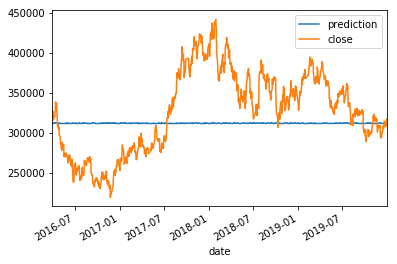

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

comparing[['prediction','close']].plot()

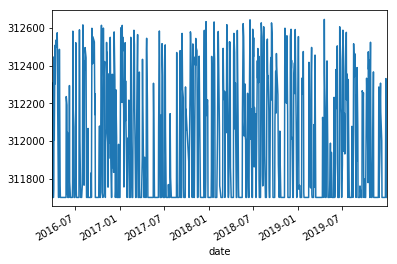

In [72]:
comparing['prediction'].plot()